In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import cv2
import mimetypes
import fnmatch
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook

### Make a file with paths

In [2]:
f = open('paths_x10.txt', 'w')
folder = []
for i in os.walk('../Data/burnasyan_Br_x10'):
    folder.append(i)
for address, dirs, files in folder:
    for file in files:
        if mimetypes.guess_type(file)[0] == 'image/jpeg':
            f.write(os.path.join(address, file) + '\n') 
f.close()
with open('paths_x10.txt', 'rb+') as filehandle:
    filehandle.seek(-1, os.SEEK_END)
    filehandle.truncate()

### Split & view distributions

In [3]:
with open('../Data/burnasyan_Br.csv') as f:
    reader = list(csv.reader(f))
idx_list = np.array(reader)[1:, 0].astype(np.int32)

In [4]:
number_of_imgs = np.array(reader)[1:, -4:].astype(np.int32)
number_of_imgs_real = np.empty_like(number_of_imgs)
dir_paths = []
for dir_i in folder[0][1]:
    dir_paths.append(os.path.join('../Data/burnasyan_Br_x10/', dir_i))
dir_paths = np.array(dir_paths)
for dir_i in dir_paths:
    i = int(dir_i.split("/")[3]) - 1
    path = os.path.join(dir_i, 'ув10__300')
    number_of_imgs_real[i, 0] = len(fnmatch.filter(os.listdir(path), '*.jpg'))
    path = os.path.join(dir_i, 'ув10__500')
    number_of_imgs_real[i, 1] = len(fnmatch.filter(os.listdir(path), '*.jpg'))

In [5]:
obj10_300 = np.sum(number_of_imgs_real[:,0].astype(np.int32), axis = 0)
obj10_500 = np.sum(number_of_imgs_real[:,1].astype(np.int32), axis = 0)

In [6]:
print('Amount of images x10: ', obj10_300 + obj10_500)

Amount of images x10:  32260


In [7]:
print('Amount of images 300x300: ', obj10_300)
print('Amount of images 500x500: ', obj10_500)

Amount of images 300x300:  22370
Amount of images 500x500:  9890


Распределение этих картинок по классам

In [8]:
labels_map = {
    "Benign": 0,
    "InSitu": 1,
    "Invasive": 2,
}

labels_map_inv = {
    0: "Benign",
    1: "InSitu",
    2: "Invasive",
}

In [9]:
with open('paths_x10.txt', 'r') as file:
    img_paths = file.read().split('\n')
    
img_paths = np.array(img_paths)
y = []
img_labels = pd.read_csv('../Data/burnasyan_Br.csv')
for item in img_paths:
    img_folder = int(item.split("/")[3])
    label_name = img_labels.iloc[img_folder - 1][4]
    label = labels_map[label_name]
    y.append(label)
train_paths, val_test_paths, y_train, y_val_test = train_test_split(img_paths, y, train_size=0.8,
                                                     random_state=42, stratify=y)

val_paths, test_paths, y_val, y_test = train_test_split(val_test_paths, y_val_test,
                                                          test_size=0.5,random_state=42,
                                                          stratify=y_val_test)
print("Train size: ", train_paths.shape[0])
print("Val size: ", val_paths.shape[0])
print("Test size: ", test_paths.shape[0])

with open('train_paths_x10.txt', 'w') as file:
    for i in range(train_paths.shape[0] - 1):
        file.write(train_paths[i] + '\n')  
    file.write(train_paths[train_paths.shape[0] - 1])
    
with open('val_paths_x10.txt', 'w') as file:
    for i in range(val_paths.shape[0] - 1):
        file.write(val_paths[i] + '\n')  
    file.write(val_paths[val_paths.shape[0] - 1])
    
with open('test_paths_x10.txt', 'w') as file:
    for i in range(test_paths.shape[0] - 1):
        file.write(test_paths[i] + '\n')  
    file.write(test_paths[test_paths.shape[0] - 1])

Train size:  25808
Val size:  3226
Test size:  3226


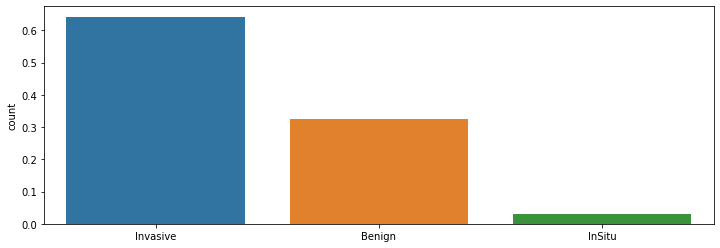

In [10]:
counts = defaultdict(int)
for l in y:
    counts[labels_map_inv[l]] += 1 / img_paths.shape[0]

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None

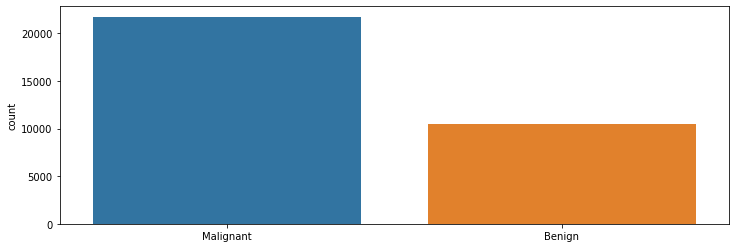

In [11]:
c = defaultdict(int)
for l in y:
    c[labels_map_inv[l]] += 1 
    
counts = defaultdict(int)
counts["Benign"] = c["Benign"]
counts["Malignant"] = c["InSitu"] + c["Invasive"]

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None

In [12]:
print("Benign: ", counts["Benign"])
print("Malignant: ", counts["Malignant"])

Benign:  10516
Malignant:  21744


In [13]:
train_counts = defaultdict(int)
for l in y_train:
    train_counts[l] += 1 / train_paths.shape[0]

train_counts_df = pd.DataFrame.from_dict(train_counts, orient='index')
train_counts_df.columns = ['train_count']
train_counts_df.sort_values('train_count', ascending=False, inplace=True)

val_counts = defaultdict(int)
for l in y_val:
    val_counts[l] += 1 / val_paths.shape[0]

val_counts_df = pd.DataFrame.from_dict(val_counts, orient='index')
val_counts_df.columns = ['val_count']
val_counts_df.sort_values('val_count', ascending=False, inplace=True)

test_counts = defaultdict(int)
for l in y_test:
    test_counts[l] += 1 / test_paths.shape[0]

test_counts_df = pd.DataFrame.from_dict(test_counts, orient='index')
test_counts_df.columns = ['test_count']
test_counts_df.sort_values('test_count', ascending=False, inplace=True)

In [14]:
counts_df = pd.concat([train_counts_df,val_counts_df,test_counts_df], axis=1)
counts_df.head()

,train_count,val_count,test_count
2,0.642126,0.642281,0.641971
0,0.325984,0.325790,0.326100
1,0.031889,0.031928,0.031928


## Examples of data

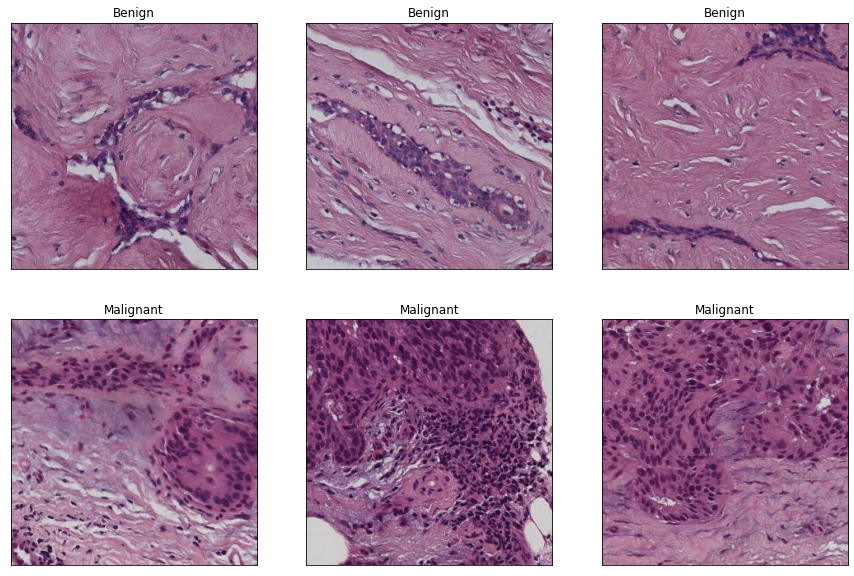

In [30]:
n = 2
m = 3

fig, ax = plt.subplots(n, m, figsize=(15, 10))
# Benign - 1 row
counter = 0
col = 0
for i in range(len(img_paths)):
    if counter < m and y[i] == 0:
        img = Image.open(img_paths[i])
        ax[0][col].get_xaxis().set_visible(False)
        ax[0][col].get_yaxis().set_visible(False)
        ax[0][col].set_title("Benign")
        ax[0][col].imshow(img)
        counter += 1
        col += 1
    elif counter >= m:
        break
# Malignant - 2 row
counter = 0
col = 0
for i in range(len(img_paths)):
    if counter < m and y[i] >= 1:
        img = Image.open(img_paths[i])
        ax[1][col].get_xaxis().set_visible(False)
        ax[1][col].get_yaxis().set_visible(False)
        ax[1][col].set_title("Malignant")
        ax[1][col].imshow(img)
        counter += 1
        col += 1
    elif counter >= m:
        break

plt.show()

In [25]:
plt.close(fig)

In [28]:
from PIL import Image